In [29]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from collections import Counter
from xgboost import XGBClassifier

In [8]:
# Load the data
df = pd.read_csv("../../data/processed/product_services_data.csv")
segmentation = pd.read_csv("../../data/processed/segmentation_result_static.csv")

## 1. How can we accurately predict individual customer preferences and needs?

### Develop a recommendation system to suggest relevant products and services.
### Identify key factors influencing customer preferences

### Data Cleaning

#### Conversion of ordinal data types with 'Unknown' values
Data is converted to the appropriate data type for data transformation and feature selection. Since many models are unable to deal with non-numerical data, categorical data must be converted to an appropriate data type via methods such as label encoding (only for ordinal variables) and one-hot encoding.

As there are individuals marked 'Unknown' in some ordinal variables (Education_Level and Income_Category), some decisions must be made on how to handle them since ordinal variables are ranked. 

While the collection method is not known, the assumption has been made that demographic data for Education_Level and Income_Category are obtained through methods such as transactions, credited salary to a bank account, loan applications and the likes. As these processes are usually automated or likely to be meticulously documented (banks are likely to have proper SOP in place that makes it highly unlikely that the data was not documented, particularly since stakes are high), and thus the data is not likely to be missing completely at random. It is more likely that these individuals with variables marked 'Unknown' have not engaged with any products and services offered by the bank, and thus the bank does not have any data on these individuals. 

As the segmentation model does not consider rows with variables marked 'Unknown' at all, for consistency, they will be dropped implicitly.

#### Product variables
Each product has 7 customizable options selected by customers, each with 2, 3, or 4 ordinal values possible:

A product is simply a vector with length 7 whose values are chosen from each of the options listed above. The cost of a product is a function of both the product options and customer characteristics.

`A`: credit cards\
`B`: savings accounts\
`C`: investments\
`D`: personal insurance\
`E`: commercial insurance\
`F`: personal loans\
`G`: commercial loans

#### Target variables
All the original product columns have integers values representing what service or product tier the customer is currently paying for. As the recommendation system would recommend what products and not what tier users should get, the product columns will be turned into binary in the following manner:

**0**: The customer does not have the product\
**1**: The customer has the product

There are some products where all customers have the product (perhaps something like a savings account), and thus in those cases:

**0**: The customer has the lowest tier of the product\
**1**: The customer has an upgraded version of the product

In [9]:
# Remove Unknown 
df1 = df.drop(columns='Unnamed: 0')
df1 = df1.set_index('CLIENTNUM').join(segmentation.set_index('CLIENTNUM'), on=['CLIENTNUM'], how='inner').reset_index()

# Convert into appropriate data type
levels = {
    'Education_Level': ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
    'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
    'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum'],
    'Gender': ['M', 'F']
}
categorical = {
    'Marital_Status': ['Married', 'Single', 'Divorced']
}

for col in df1.columns:
    if is_object_dtype(df1[col]):
        if col in levels.keys():
            '''
            if 'Unknown' in df[col].unique():
                # Keep track of columns with imputed values
                df1[f"{col}_NA"] = df1[col].eq('Unknown').astype(int)
                
                # Impute 'Unknown' values with the mode of the column
                mode_value = df1[col].mode()[0]
                df1[col] = df1[col].replace('Unknown', mode_value)'''
            
             # Label encoding
            df1[col] = pd.Categorical(df1[col], categories=levels[col], ordered=True)
            df1[col] = df1[col].cat.codes

# One hot encoding
df1 = pd.get_dummies(df1)

df1.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,C,D,E,F,G,risk_factor,Loyalty,Financial_Status,Segment,Digital_Capability
0,768805383,1,45,1,3,1,1,2,1,39,...,3.0,2.0,1.0,0.0,0.0,1.0,3,3,1,True
1,818770008,1,49,0,5,3,0,4,1,44,...,4.0,2.0,0.0,0.0,0.0,3.0,3,6,2,True
2,713982108,1,51,1,3,3,1,3,1,36,...,0.0,3.0,0.0,0.0,3.0,3.0,2,3,1,True
3,709106358,1,40,1,3,0,1,2,1,21,...,0.0,3.0,0.0,0.0,3.0,1.0,3,5,2,True
4,713061558,1,44,1,2,3,1,1,1,36,...,1.0,2.0,1.0,0.0,4.0,4.0,2,6,2,False


In [10]:
# Convert products into binary 
product_list = set(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
features_list = list(set(df1.columns).difference(product_list))
features_list.remove('CLIENTNUM')

df2 = df1
for product in product_list:
    # Since minimum is 1, the recommendation would be based on whether an upgrade should be recommended
    if product in ['C', 'D', 'G']:
        df2[product] = np.where(df2[product] > 1, 1, 0)
    # Some users do not have this product at all
    else:
        df2[product] = np.where(df2[product] > 0, 1, 0)

product_list = list(product_list)
product_list.sort()

In [11]:
# Save cleaned dataset
df2.to_csv("../../data/processed/recommendation_system_dataset.csv")

### EDA: Identify key features
There are many columns, and not all of them are relevant. Including them all would cause an unnecessary increase in the input dimension, which makes it difficult for the model to identify relevant relationships, among other issues.

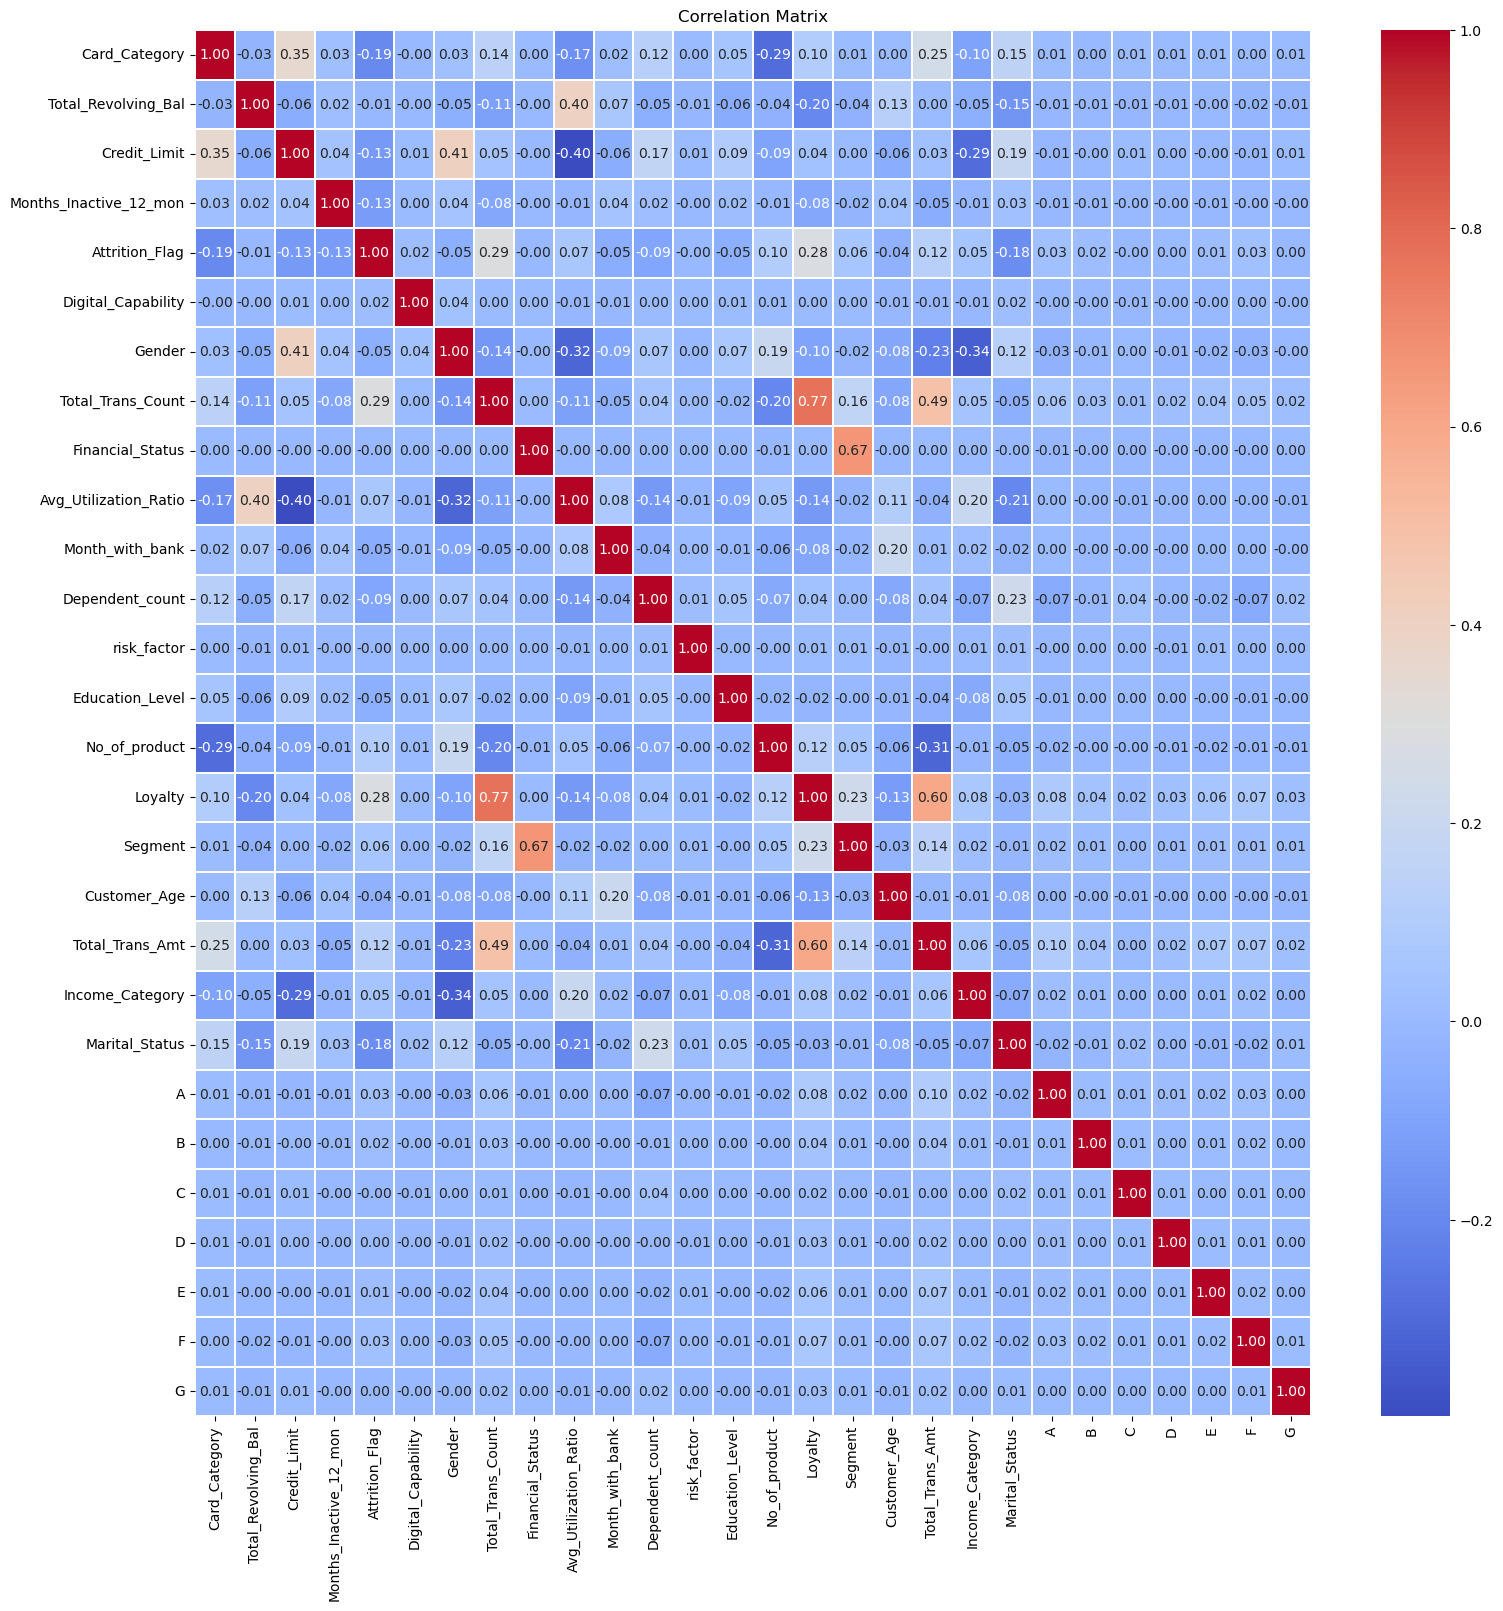

In [5]:
# Examine correlation
correlation_matrix = df2[features_list+list(product_list)].corr()

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, it can be seen that although there are some strong correlation between features, such as between Avg_Open_To_Buy and Credit_Limit, Total_Trans_Amt and Total_Trans_Ct, the boolean columns on whether clients purchase insurance products (A, B, C, D, E, F, G) are very weakly correlated with the rest of the dataset. This means that there is no strong linear relationship between the products and other features, and thus have no bearing on the outcome (i.e. whether a client purchases the insurance product). This is to be expected, given that the product variables are synthetic data and have no relationship with the other variables. 

There also does not seem to be any pairwise or multivariate (since the correlation values are too low to indicate any relationship between them) correlation between them. This is also expected, as even though the distribution of results was preserved, the relationship between products were not. Ideally, this would be helpful in identifying complementary or substitute products that could be recommended.

High correlations between other variables mean it would be redundant to keep all correlated features, since they would increase dimensionality without contributing much to the model. Thus, feature selection must be done to remove some highly correlated features to improve model performance.


In [12]:
# Count the number of people in each segment
cluster_count = df2[['Segment', 'CLIENTNUM']].groupby('Segment').count()
display(cluster_count)

,CLIENTNUM
Segment,
1,7543
2,83945
3,3843
4,14172
5,621


From the count of each cluster, it seems that Segment 2 had the highest number of clients. From the analysis done in Subgroup A Q1, these clients are ``High Financial status, High Loyalty``. This is the most important group to be targeting, as they are likely the clients who will engage with the products the most and thus must be prioritised. 

Another important cluster would be Segment 3, who are financially able to purchase products, but may not have the willingness to. Finding products suitable for these clients would result in new streams of income, and it is thus worthwhile to examine this cluster closely. 

Since clients would only purchase products they are financially able to afford, income is a very important factor on the customers' ability to purchase. Thus, two recommendation systems will exist for each product: 
- a recommendation system catering to high income customers in Segments 4 and 5,
- a recommendation system catering to medium income customers in Segment 2, and
- a recommendation system catering to low income customers in Segments 1 and 3\

This ensures that there is sufficient users to train and validate a model and identify products that may be attractive less loyal clients, opening up new streams of revenue.

Since there are many features and each product will have a different relationship with the other variables and thus different degree of importance, an automated feature selection method would be helpful to identify key features. SelectKBest is hence utilised to find the features features with the highest degree of relevance for clients to subscribe to a product. The number of features for each product and cluster is limited to 10.

In [ ]:
# Define training cluster
clusters = {'low_income': [1, 3], 'medium_income': [2],'high_income': [4, 5]}

# Choose the best features
def select_best(x, y, k = 10, score_func=f_regression):
    '''
    Select k best feature with SelectKBest
    Input:
    x: training features
    y: target variable
    Optional:
    k = number of training features selected
    score_func: score function used to evaluate features
    Returns:
    list of k best features, dataframe of scores and p-value of all features
    '''
    KBest = SelectKBest(score_func, k=k)
    KBest = KBest.fit(x, y)

    cols = KBest.get_support(indices=True)
    cols = x.columns[cols]

    return np.array(cols), pd.DataFrame({'features': x.columns, 'score': KBest.scores_, 'p-value': KBest.pvalues_ })


def obtain_best_columns(df, clusters, product_list):
    '''
    Obtain best columns for each product in each cluster
    Input:
    df: dataframe
    clusters: dictionary of clusters
    product_list: list of products
    Returns:
    dictionary of list of best features, dictionary of dataframe of scores and p-value of all features
    '''
    scores = {key:{} for key in clusters.keys()}
    cols = {key:{} for key in clusters.keys()}
    for key, cluster in clusters.items():
        df_cluster = df[df['Segment'].isin(cluster)].drop(columns=['CLIENTNUM'])

        for product in product_list:
            X = df_cluster.drop(columns=[product])
            cols[key][product], scores[key][product] = select_best(X, df_cluster[product])
    return cols, scores

cols, scores = obtain_best_columns(df2, clusters, product_list)

In [15]:
cols['high_income']['A']

array(['Attrition_Flag', 'Gender', 'Dependent_count', 'Marital_Status',
       'No_of_product', 'Total_Trans_Amt', 'Total_Trans_Count', 'E', 'F',
       'Loyalty'], dtype=object)

In [16]:
scores['low_income']['A'].head()

,features,score,p-value
0,Attrition_Flag,18.742257,1.509089e-05
1,Customer_Age,0.770008,3.802331e-01
2,Gender,22.321326,2.333898e-06
3,Dependent_count,64.305894,1.169403e-15
4,Education_Level,6.133479,1.327898e-02


In [ ]:
# Key features for every product
flattened_features = []
for sub_dict in cols.values():
    for feature_list in sub_dict.values():
        flattened_features.extend(feature_list)
feature_relevance = dict(Counter(flattened_features))
feature_relevance = pd.DataFrame(feature_relevance.items(), columns=['feature', 'count']).sort_values('count', ascending=False)
feature_relevance.head(10)

,feature,count
7,Loyalty,21
4,Total_Trans_Amt,18
5,Total_Trans_Count,18
1,Dependent_count,14
6,F,14
0,Gender,12
10,Attrition_Flag,12
8,Financial_Status,11
2,Marital_Status,11
12,A,10


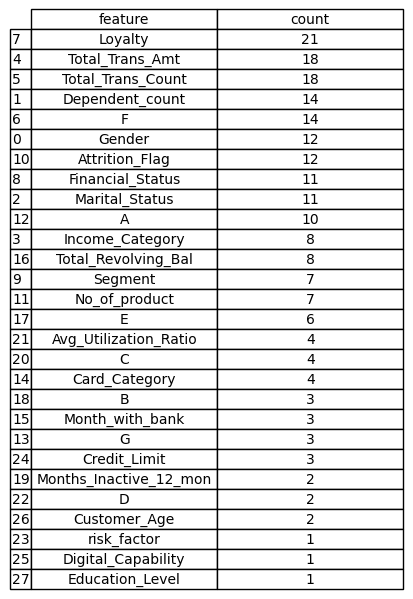

In [20]:
# display as table
fig, ax = plt.subplots(figsize=(4, 6))

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(cellText=feature_relevance.to_numpy(), 
                 colLabels=feature_relevance.columns, 
                 rowLabels=feature_relevance.index, 
                 cellLoc='center', 
                 loc='center')

# Adjust the table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Display the plot
plt.show()

#### Model training and testing
The model utilised to answer this question is XGBoost for the following reasons:
1. To incorporate demographic data\
In a banking context, it is important to consider the demographic of users into the recommendation model due to its availability and because it determines the types of products and services they subscribe to. A student and a retiree would have very different financial needs and ability, and this should be taken into account. Thus, collaborative filtering and content-based filtering models may be insufficient as they focus only on the products subscribed.
2. The prevalence of categorical variables in the dataset\
The dataset contains many categorical variables, decision tree architectures may be more suitable. Furthermore, as XGBoost utilises decision trees, normalising/standardising columns are not required, which would have been difficult to do with categorical columns.
3. Interpretability\
Some degree of interpretability is required in a banking context, as decisions should be explainable to key stakeholders. The main issue with ML models is that often times they are not very interpretable. In high risk industries that deals with large amounts of money like banking, business decisions should be interpretable so that they can be justified.

The model will output a probability on whether a client should be recommended a particular product. Its input can include other products that customers are subscribed to, and the actual labels are whether the client is subscribed to that product.

There are 14 models in total, a permutation of product type (``A``, ``B``, `C`, ``D``, ``E``, ``F``, ``G``) and cluster (``low_income``, ``medium_income``, ``high_income``)

In [30]:
def model_train_test(df, cols, clusters, product_list):
    '''
    Train XGBoost models and predict output
    Input:
    df: dataframe
    cols: columns for training
    clusters: dictionary of clusters
    product_list: list of products
    Returns:
    dictionary of predicted labels, dictionary of ground truth labels
    '''
    predicted_labels = {key: {} for key in clusters.keys()}
    actual_labels = {key: {} for key in clusters.keys()}

    # Loop through clusters and products
    for key, cluster in clusters.items():
        users = df[df['Segment'].isin(cluster)]
        for i in product_list:
            # Define the target variable for the product
            y = users[['CLIENTNUM', i]].set_index('CLIENTNUM')
            
            # Set up training features from selected columns
            training_features = users[list(cols[key][i]) + ['CLIENTNUM']]
            training_features = training_features.set_index('CLIENTNUM')
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(training_features, y, test_size=0.4, random_state=123)
            
            # Train XGBClassifier
            bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
            bst.fit(X_train.to_numpy(), y_train.to_numpy())
            
            # Prediction
            predicted_labels[key][i] = pd.DataFrame(bst.predict_proba(X_test.to_numpy())[:, 1], index=X_test.index, columns=[i])
            actual_labels[key][i] = pd.DataFrame(y_test, index=y_test.index, columns=[i])
    return predicted_labels, actual_labels

predicted_labels, actual_labels = model_train_test(df2, cols, clusters, product_list)

### Model evaluation


In [31]:
def get_results(results, source):
    '''
    Returns prediction for all products in a single dataframe
    Input:
    results: dictionary of labels
    source: the cluster data was taken from 
    Returns:
    dataframe of predictions
    '''
    products = list(results.keys())
    final_df = results[products[0]]
    for key in products[1:]:
        final_df = final_df.merge(results[key], on='CLIENTNUM', how='left')
    final_df['Cluster'] = source
    return final_df

In [39]:
# Combine predictions
source = list(clusters.keys())[0]
pldf = get_results(predicted_labels[source], source)

source = list(clusters.keys())[1]
pldf = pd.concat([get_results(predicted_labels[source], source), pldf])

display(pldf)

,A,B,C,D,E,F,G,Cluster
CLIENTNUM,,,,,,,,
524383225,0.623195,0.495373,0.738586,0.812909,0.449861,0.680653,0.732308,medium_income
869671622,0.578122,0.476017,0.771455,0.808579,0.449861,0.608818,0.750338,medium_income
745705955,0.313323,0.373643,0.771455,0.731951,0.301727,0.320614,0.619463,medium_income
640110534,0.578122,0.476017,0.771455,0.789855,0.449861,0.608818,0.750338,medium_income
608388801,0.653772,0.495373,0.750348,0.799575,0.492667,0.704171,0.724074,medium_income
...,...,...,...,...,...,...,...,...
119855798,0.310581,0.394425,0.708847,0.753381,0.287460,0.366817,0.602211,low_income
998777005,0.648492,0.473428,0.696728,0.823442,0.434078,0.684433,0.713311,low_income
717217983,0.575360,0.540049,0.768504,0.822883,0.434078,0.632043,0.713311,low_income


### Save predictions for API call


In [40]:
predictions = pldf.copy()
predictions.columns = ['credit_cards', 'savings_accounts', 'investments', 'personal_insurance', 'commercial_insurance', 'personal_loans', 'commercial_loans', 'Cluster']
predictions.to_csv("../../data/predictions/BQ1.csv")

### Evaluation
Evaluation metrics used:\
*Standard performance metrics*
- Confusion matrix
- F1 score
*Specific evaluation metrics*


In [37]:
# Get actual labels
# Combine predictions
source = list(clusters.keys())[0]
aldf = get_results(actual_labels[source], source)

source = list(clusters.keys())[1]
aldf = pd.concat([get_results(actual_labels[source], source), aldf])

display(aldf)

,A,B,C,D,E,F,G,Cluster
CLIENTNUM,,,,,,,,
524383225,1,0,1,1,0,1,1,medium_income
869671622,1,0,1,1,0,0,1,medium_income
745705955,0,0,1,1,0,1,1,medium_income
640110534,1,1,0,1,0,1,0,medium_income
608388801,1,0,1,1,1,1,1,medium_income
...,...,...,...,...,...,...,...,...
119855798,0,0,1,0,0,0,0,low_income
998777005,0,1,1,1,1,0,1,low_income
717217983,0,0,0,1,0,0,1,low_income


In [45]:
# Obtain labels data
actual = aldf.drop(columns=['Cluster'])
predicted = pldf.drop(columns=['Cluster']).apply(lambda x: np.where(x > 0.65, 1, 0))

# Get accuracy
confusion_matrixes = {}
accuracy = {}
for col in actual.columns:
    confusion_matrixes[col] = confusion_matrix(actual[col], predicted[col])
    accuracy[col] = accuracy_score(actual[col], predicted[col])

In [46]:
# The count of true negatives is C00, false negatives is C10, true positives is C11 and false positives is C01
confusion_matrixes

{'A': array([[11602,  3475],
        [15432,  7624]], dtype=int64),
 'B': array([[19822,    14],
        [18288,     9]], dtype=int64),
 'C': array([[   89,  9602],
        [  254, 28188]], dtype=int64),
 'D': array([[    5,  7776],
        [   13, 30339]], dtype=int64),
 'E': array([[20529,     0],
        [17604,     0]], dtype=int64),
 'F': array([[ 8191,  5886],
        [10850, 13206]], dtype=int64),
 'G': array([[  557,  9823],
        [ 1047, 26706]], dtype=int64)}

In [47]:
# Accuracy
accuracy

{'A': 0.5041827288700076,
 'B': 0.5200482521700365,
 'C': 0.7415362022395301,
 'D': 0.795741221514174,
 'E': 0.5383526079773424,
 'F': 0.5611150447119293,
 'G': 0.7149450607085727}